# The Minority Math Problem

#### Where to invest in new York city to elevate minority representation in mathematics

Jeremy Owens

In STEM areas of study, there is a significant lack of minority presence. One of the most tangible ways for us to improve the level of diversity is to get minority students more involved at the grade school and high school levels. In New York City, there are a number of magnet type schools focused on math and the sciences that can give students a significant leg up in their STEM careers, and this project aims to show how we can grow the minority presence in these schools.

This project will look to create a predictive model for schools with high math scores, and then look to the schools that are underperforming (where the model predicts that, given the factors present, the school should have high math scores, but in fact does not). We then look at the differences between the underperforming population and the true to performance population, to see where the city can invest its resources to have the greatest impact in schools that are underperforming against expectations and have a majority minority population.

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from scipy import stats
from HelperFunctions import HelperFunctions as hf

%matplotlib inline
sns.set_style("darkgrid")

## Data Cleaning / EDA

We begin our process by reading in the 2016 School Explorer Dataset and eliminating a variety of columns that are not useful to our analysis.

In [2]:
initial_df = pd.read_csv('2016 School Explorer.csv')
schools_df = hf.drop_impractical_columns(initial_df)

In [3]:
schools_df['Student Achievement Rating'] = schools_df['Student Achievement Rating'].apply(lambda x: hf.acheivement_score(x))
schools_df['Student Achievement Rating'].fillna(schools_df['Student Achievement Rating'].median(), inplace=True)

In [4]:
schools_df.dropna(inplace=True)

In [5]:
schools_df = hf.percent_cols_to_float(schools_df)

Dropping the race statistics and storing for later use after prediction.

In [6]:
races_to_drop = ['Percent ELL',
                 'Percent Asian',
                 'Percent Black',
                 'Percent Hispanic',
                 'Percent Black / Hispanic',
                 'Percent White']
race_df = schools_df[['Location Code'] + races_to_drop].set_index('Location Code')
schools_df = schools_df.drop(races_to_drop, axis=1).set_index('Location Code')

In [7]:
schools_df['Grade Low'] = schools_df['Grade Low'].apply(lambda x: hf.make_grades_int(x))
schools_df['Grade High'] = schools_df['Grade High'].apply(lambda x: hf.make_grades_int(x))
schools_df['Grade_range'] = schools_df['Grade High'] - schools_df['Grade Low']
schools_df.drop(['Grade Low', 'Grade High'], axis=1, inplace=True)

### Incorportation of Additional Data

Importing the Pupil to Teacher dataset for joining to main dataset.

In [8]:
pupil_teacher_ratio_df = pd.read_csv('2015_-_2016_Final_Class_Size_Report_Pupil-to-Teacher_Ratio__PTR_.csv')
pupil_teacher_ratio_df = pupil_teacher_ratio_df.drop('School Name', axis=1).set_index('DBN')

In [9]:
joined_df = schools_df.join(pupil_teacher_ratio_df)

In [10]:
display(joined_df.info())
display(joined_df.head())
display(race_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1217 entries, 01M015 to 84X730
Data columns (total 13 columns):
Economic Need Index                       1217 non-null float64
Student Attendance Rate                   1217 non-null float64
Percent of Students Chronically Absent    1217 non-null float64
Rigorous Instruction %                    1217 non-null float64
Collaborative Teachers %                  1217 non-null float64
Supportive Environment %                  1217 non-null float64
Effective School Leadership %             1217 non-null float64
Strong Family-Community Ties %            1217 non-null float64
Trust %                                   1217 non-null float64
Student Achievement Rating                1217 non-null float64
Average Math Proficiency                  1217 non-null float64
Grade_range                               1217 non-null int64
School Pupil-Teacher Ratio                1083 non-null float64
dtypes: float64(12), int64(1)
memory usage: 173.1+ KB


None

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %,Student Achievement Rating,Average Math Proficiency,Grade_range,School Pupil-Teacher Ratio
Location Code,,,,,,,,,,,,,
01M015,0.919,0.94,0.18,0.89,0.94,0.86,0.91,0.85,0.94,2.0,2.17,6,9.2
01M019,0.641,0.92,0.30,0.96,0.96,0.97,0.90,0.86,0.94,4.0,2.98,6,7.0
01M020,0.744,0.94,0.20,0.87,0.77,0.82,0.61,0.80,0.79,2.0,2.54,6,13.3
01M034,0.860,0.92,0.28,0.85,0.78,0.82,0.73,0.89,0.88,4.0,2.47,9,10.9
01M063,0.730,0.93,0.23,0.90,0.88,0.87,0.81,0.89,0.93,3.0,2.54,6,10.6


,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White
Location Code,,,,,,
01M015,0.09,0.05,0.32,0.60,0.92,0.01
01M019,0.05,0.10,0.20,0.63,0.83,0.06
01M020,0.15,0.35,0.08,0.49,0.57,0.04
01M034,0.07,0.05,0.29,0.63,0.92,0.04
01M063,0.03,0.04,0.20,0.65,0.84,0.10


We then look at our (mostly) final dataframe to check for significant outliers.

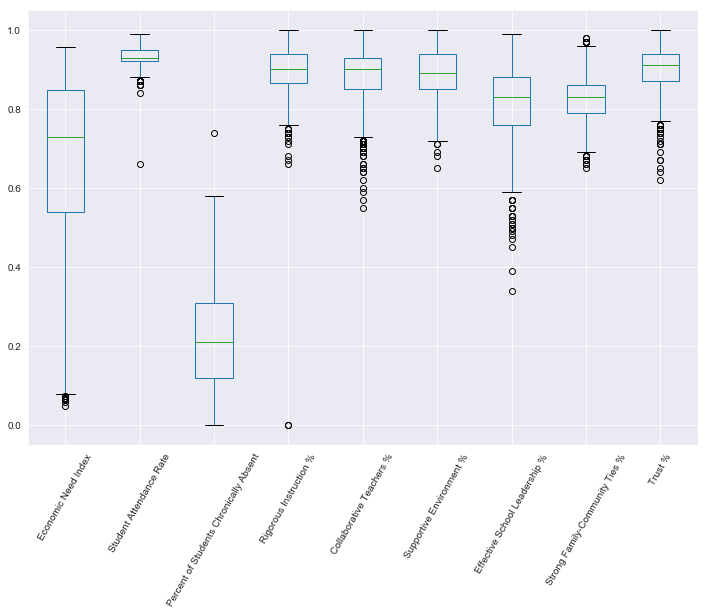

In [11]:
percentage_stats = joined_df.columns[:9]
joined_df.dropna()[percentage_stats].boxplot(figsize=(12,8))
plt.xticks(rotation=60)
plt.show()

From this, we remove any data points where the rigorous instruction percentage is equal to 0 (an obvious outlier in the data).

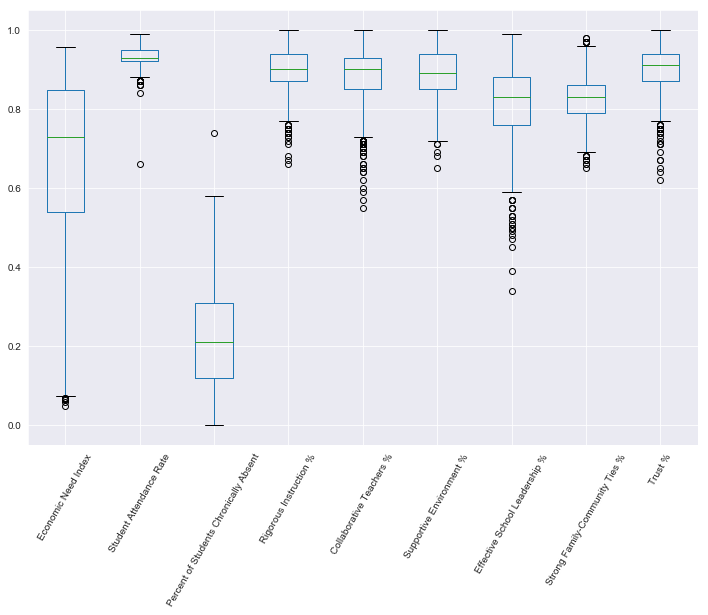

In [12]:
warnings.filterwarnings('ignore')
final_df = joined_df.dropna()
instruction_outliers_indexes = final_df[final_df['Rigorous Instruction %'] == 0].index
final_df.drop(instruction_outliers_indexes, inplace=True)
percentage_stats = final_df.columns[:9]
final_df[percentage_stats].boxplot(figsize=(12,8))
plt.xticks(rotation=60)
plt.show()

 We then check our other measurement metrics, to make sure nothing looks out of place.

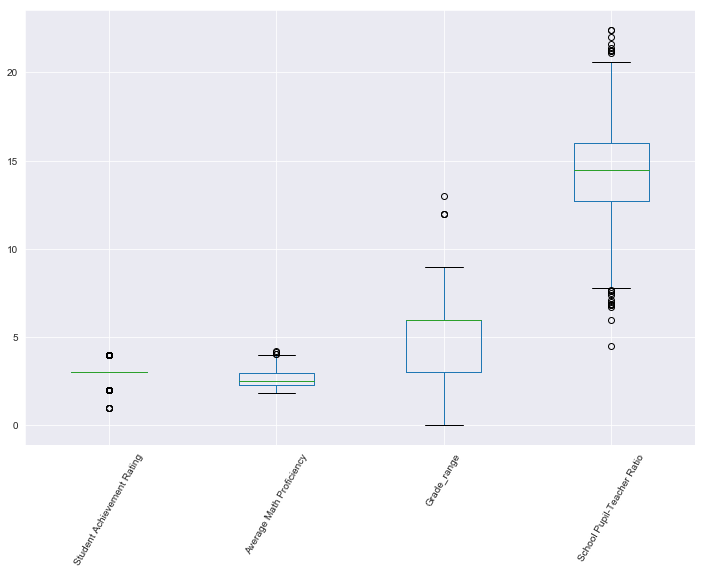

In [13]:
other_stats = final_df.columns[-4:]
final_df[other_stats].boxplot(figsize=(12,8))
plt.xticks(rotation=60)
plt.show()

And all looks good here, so we then move on to the formation of the model.

## Model Formation

We define a high math score as being in the upper quartile of the range of values in the dataset (which turns out to be a score of approximately 2.98 or above).

In [14]:
upper_quartile = final_df['Average Math Proficiency'].quantile(.75)
y = final_df['Average Math Proficiency'].apply(lambda x: 1 if x >= upper_quartile else 0)
X = final_df.drop('Average Math Proficiency', axis=1)
features = X.columns

And scale our data for analysis and bring all our values around the origin.

In [15]:
X = StandardScaler().fit_transform(X.astype({'Grade_range': 'float64'}))

### PCA Analysis

We first do a PCA analysis to determine, of our predictors, which have the greatest bearing on our classification algorithm.

In [16]:
pca = PCA()
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents)

In [17]:
pca.explained_variance_ratio_

array([0.3974852 , 0.19656456, 0.11404235, 0.06749327, 0.05960156,
       0.04559067, 0.04052775, 0.03527883, 0.02483774, 0.00859648,
       0.0067893 , 0.00319229])

In [18]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_

In [19]:
structure_loading_1 = eig_vectors[0]* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=features)
str_loading_1.sort_values(ascending=False)

Percent of Students Chronically Absent    0.654653
Economic Need Index                       0.573251
Grade_range                              -0.112935
School Pupil-Teacher Ratio               -0.377194
Student Achievement Rating               -0.449336
Strong Family-Community Ties %           -0.507848
Student Attendance Rate                  -0.644946
Rigorous Instruction %                   -0.733685
Supportive Environment %                 -0.757446
Effective School Leadership %            -0.763228
Trust %                                  -0.784523
Collaborative Teachers %                 -0.822339
dtype: float64

Text(0, 0.5, 'proportion of explained variance')

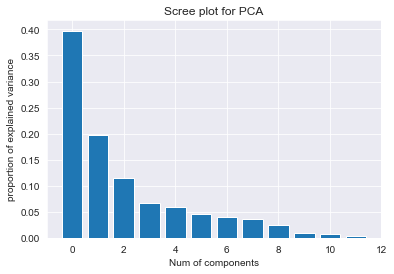

In [20]:
index = np.arange(len(features))
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('proportion of explained variance')

Text(0, 0.5, 'explained variance ratio')

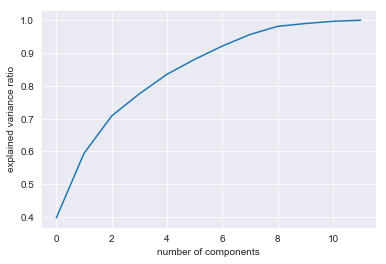

In [21]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')

While this was a useful exercise to look at the number of useful factors in this analysis, as we would want to ideally use 8 out of the 12 components to acheive a decent portion of explained variance, we determined it would be beneficial to keep the original 12 predictors in model analysis, and only cull that number should feature importance dictate.

So we next use the recursive feature elimination tool from SKLearn to determine which of our features are superfluous to the model, and would likely introduce too much noise, causing overfit.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

In [23]:
hf.rfe_test(DecisionTreeClassifier(), features, X_train, y_train)

,0,1
0,Economic Need Index,1.00
1,Student Attendance Rate,1.00
5,Supportive Environment %,1.00
9,Student Achievement Rating,1.02
7,Strong Family-Community Ties %,1.06
3,Rigorous Instruction %,1.10
2,Percent of Students Chronically Absent,1.32
8,Trust %,1.38
11,School Pupil-Teacher Ratio,1.46
6,Effective School Leadership %,1.48


In [24]:
hf.rfe_test(RandomForestClassifier(), features, X_train, y_train)

,0,1
0,Economic Need Index,1.00
1,Student Attendance Rate,1.00
2,Percent of Students Chronically Absent,1.00
5,Supportive Environment %,1.00
11,School Pupil-Teacher Ratio,1.00
9,Student Achievement Rating,1.04
7,Strong Family-Community Ties %,1.08
6,Effective School Leadership %,1.30
3,Rigorous Instruction %,1.32
4,Collaborative Teachers %,1.56


In [25]:
hf.rfe_test(XGBClassifier(), features, X_train, y_train)

,0,1
0,Economic Need Index,1.0
1,Student Attendance Rate,1.0
2,Percent of Students Chronically Absent,1.0
3,Rigorous Instruction %,1.0
4,Collaborative Teachers %,1.0
5,Supportive Environment %,1.0
6,Effective School Leadership %,1.0
7,Strong Family-Community Ties %,1.0
8,Trust %,1.0
9,Student Achievement Rating,1.0


As we can see from the Decision Tree, Random Forest, and XGBoost RFE analysis Grade_range, Trust %, and Collaborative Teachers % consistently are the lowest ranked features for importance, and likely introduce more noise than we need. We therefore will remove them from our dataset.

In [26]:
final_df.drop(['Trust %', 'Grade_range', 'Collaborative Teachers %'], axis=1, inplace=True)
X = final_df.drop('Average Math Proficiency', axis=1)
features = X.columns
final_df.head()

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Student Achievement Rating,Average Math Proficiency,School Pupil-Teacher Ratio
Location Code,,,,,,,,,,
01M015,0.919,0.94,0.18,0.89,0.86,0.91,0.85,2.0,2.17,9.2
01M019,0.641,0.92,0.30,0.96,0.97,0.90,0.86,4.0,2.98,7.0
01M020,0.744,0.94,0.20,0.87,0.82,0.61,0.80,2.0,2.54,13.3
01M034,0.860,0.92,0.28,0.85,0.82,0.73,0.89,4.0,2.47,10.9
01M063,0.730,0.93,0.23,0.90,0.87,0.81,0.89,3.0,2.54,10.6


In [27]:
X = StandardScaler().fit_transform(X)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

### Baseline Model

In [29]:
param_grid = {'strategy': ['stratified', 'most_frequent']}

Grid Search found the following optimal parameters: 
strategy: 'most_frequent'

[[221   0]
 [104   0]]
              precision    recall  f1-score   support

           0       0.68      1.00      0.81       221
           1       0.00      0.00      0.00       104

   micro avg       0.68      0.68      0.68       325
   macro avg       0.34      0.50      0.40       325
weighted avg       0.46      0.68      0.55       325

Accuracy score: 0.68


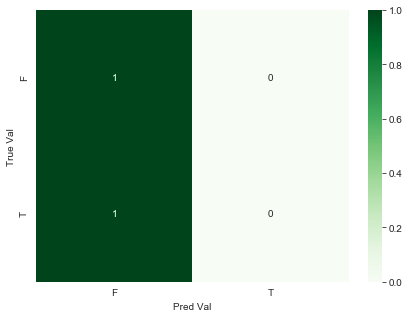

In [30]:
bs_grid_clf = hf.grid_search_classifier(DummyClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.5


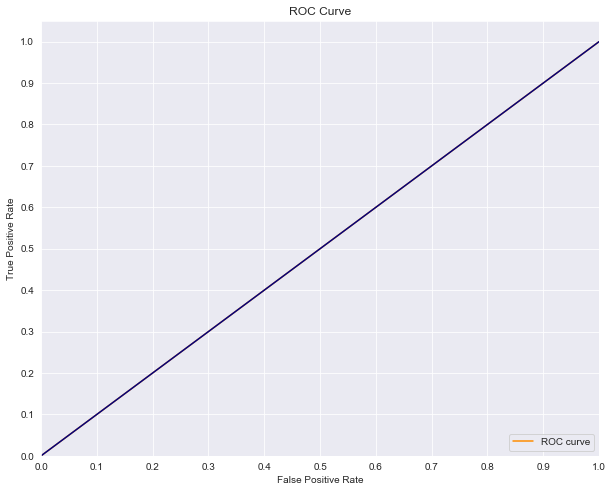

In [31]:
hf.plot_ROC(y_test, X_test, bs_grid_clf)

As we can see, our baseline model is inefficient at correctly classifying a number of schools, and our ROC lies just at the expected curve for random guessing.

### Basic Decision Tree

First, we will check our ability to classify based on a simple Decision Tree.

In [32]:
param_grid = {'max_depth': [3, 5, 10, 15],
              'max_features': [2, 5, 8, 9],
             }

Grid Search found the following optimal parameters: 
max_depth: 3
max_features: 8

[[202  19]
 [ 17  87]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       221
           1       0.82      0.84      0.83       104

   micro avg       0.89      0.89      0.89       325
   macro avg       0.87      0.88      0.87       325
weighted avg       0.89      0.89      0.89       325

Accuracy score: 0.89


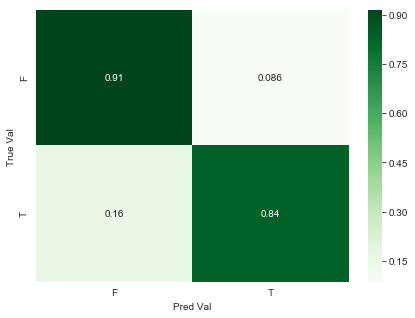

In [33]:
dt_grid_clf = hf.grid_search_classifier(DecisionTreeClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9210972850678734


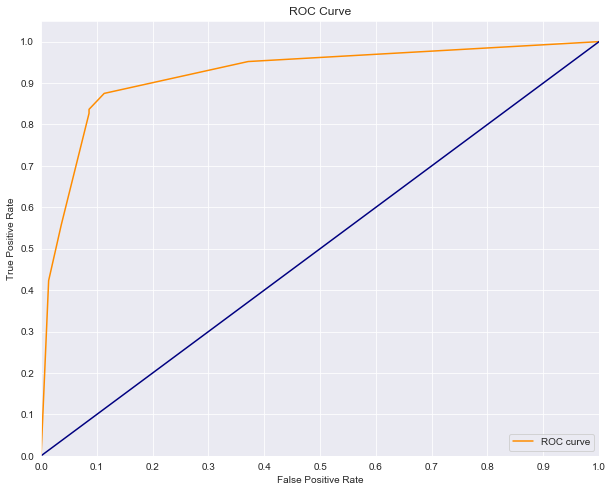

In [34]:
hf.plot_ROC(y_test, X_test, dt_grid_clf)

A significant improvement certainly, but there are still a number of schools classified as needing help that may not actually need taxpayer dollars invested, so we delve into a few other classification algorithms to see if we can improve our accuracy and f1 score.

### KNN

In [35]:
param_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': [3, 5, 8, 10, 15, 20]
             }

Grid Search found the following optimal parameters: 
n_neighbors: 15
weights: 'uniform'

[[207  14]
 [ 19  85]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       221
           1       0.86      0.82      0.84       104

   micro avg       0.90      0.90      0.90       325
   macro avg       0.89      0.88      0.88       325
weighted avg       0.90      0.90      0.90       325

Accuracy score: 0.9


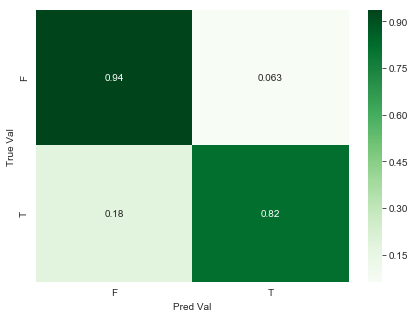

In [36]:
knn_grid_clf = hf.grid_search_classifier(KNeighborsClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9665201879568396


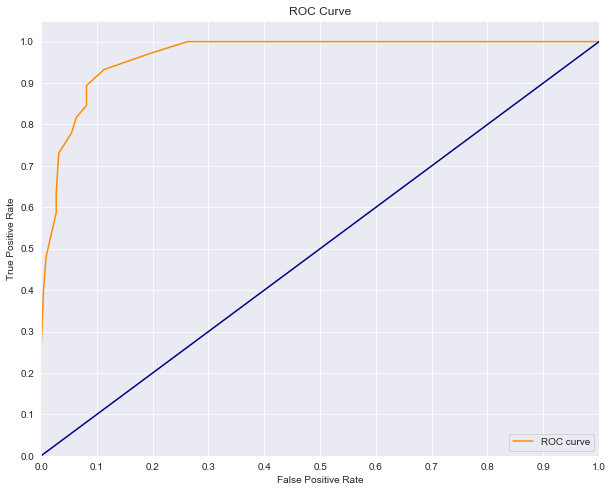

In [37]:
hf.plot_ROC(y_test, X_test, knn_grid_clf)

### Random Forest

In [38]:
param_grid = {'max_depth': [3, 5, 10, 15],
              'max_features': [2, 5, 8, 9],
              'n_estimators': [10, 25, 50, 100, 250, 500]
             }

Grid Search found the following optimal parameters: 
max_depth: 5
max_features: 2
n_estimators: 50

[[208  13]
 [ 13  91]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       221
           1       0.88      0.88      0.88       104

   micro avg       0.92      0.92      0.92       325
   macro avg       0.91      0.91      0.91       325
weighted avg       0.92      0.92      0.92       325

Accuracy score: 0.92


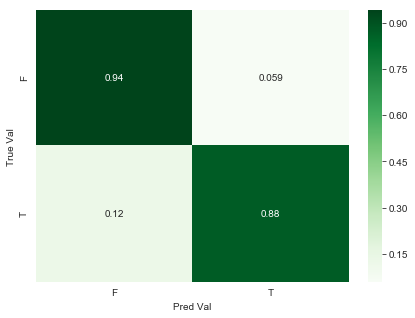

In [39]:
rf_grid_clf = hf.grid_search_classifier(RandomForestClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9668900104420466


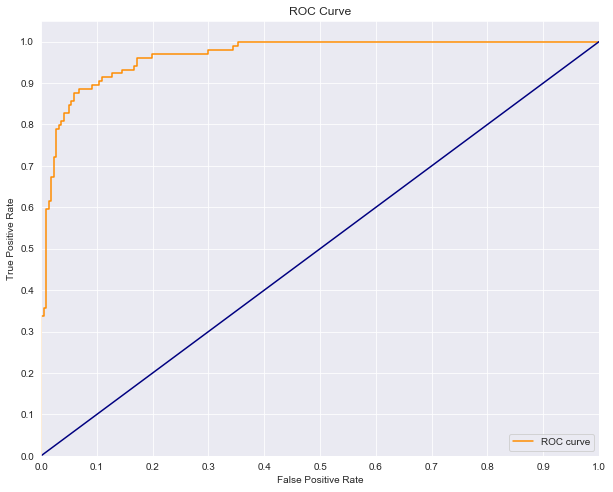

In [40]:
hf.plot_ROC(y_test, X_test, rf_grid_clf)

### SVC

In [41]:
param_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'probability': [True],
              'C': [.01, .1, 1, 10, 100],
              'degree': [2, 3, 4],
              'shrinking': [True, False]
             }

Grid Search found the following optimal parameters: 
C: 1
degree: 2
kernel: 'linear'
probability: True
shrinking: True

[[212   9]
 [ 17  87]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       221
           1       0.91      0.84      0.87       104

   micro avg       0.92      0.92      0.92       325
   macro avg       0.92      0.90      0.91       325
weighted avg       0.92      0.92      0.92       325

Accuracy score: 0.92


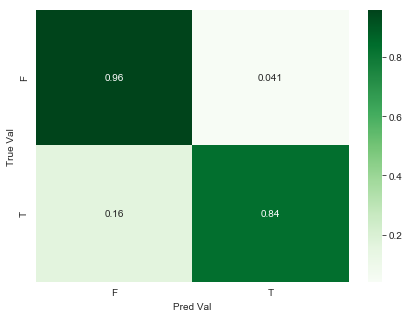

In [42]:
svc_grid_clf = hf.grid_search_classifier(SVC(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9774190741385311


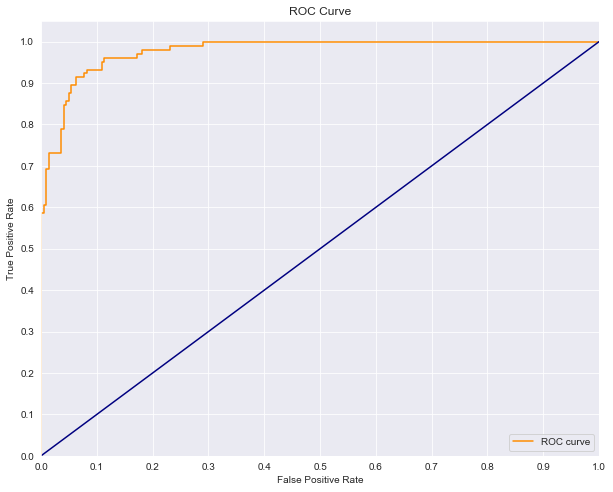

In [43]:
hf.plot_ROC(y_test, X_test, svc_grid_clf)

### XGBoost

In [44]:
param_grid = {'learning_rate': [.01, .1],
              'max_depth': [3, 5, 10, 15],
              'min_child_weight': [2, 5, 10],
              'subsample': [0.7, 0.8],
              'n_estimators': [100, 250, 500, 1000]
             }

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 2
n_estimators: 100
subsample: 0.7

[[206  15]
 [ 12  92]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       221
           1       0.86      0.88      0.87       104

   micro avg       0.92      0.92      0.92       325
   macro avg       0.90      0.91      0.91       325
weighted avg       0.92      0.92      0.92       325

Accuracy score: 0.92


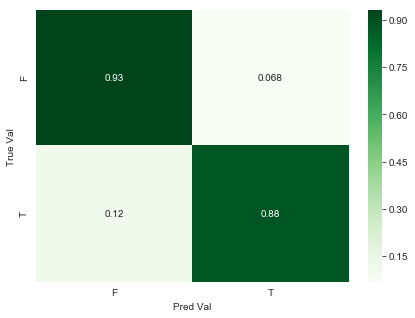

In [45]:
xgb_grid_clf = hf.grid_search_classifier(XGBClassifier(), param_grid, X_train, X_test, y_train, y_test)

AUC: 0.9662808910546468


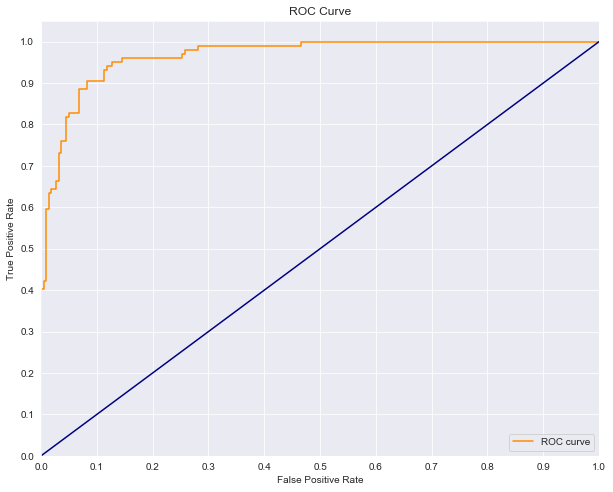

In [46]:
hf.plot_ROC(y_test, X_test, xgb_grid_clf)

## Analysis

All of these additional models perform fairly similarly, but for our purposes we will utilize the Random Forest method, as it ranks high for its f1 score and is a fairly interpretable model, should we need to modify in the future with more data.

We then set up our model to predict scores based on the best criteria found via grid search, and compare our predicted values against the actual values to determine what are our underperforming schools.

In [47]:
upper_quartile = final_df['Average Math Proficiency'].quantile(.75)
final_df['Average Math Proficiency'] = final_df['Average Math Proficiency'].apply(lambda x: 1 if x >= upper_quartile else 0)
X = final_df.drop('Average Math Proficiency', axis=1)


In [48]:
predict_df = pd.DataFrame(rf_grid_clf.predict(StandardScaler().fit_transform(X))).set_index(final_df.index)

In [49]:
final_predict_df = pd.concat([final_df, predict_df], axis=1).rename({0: 'Predicted_class'}, axis=1)
final_predict_df['Match_type'] = final_predict_df['Average Math Proficiency'] - final_predict_df.Predicted_class
final_predict_df.head()

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Student Achievement Rating,Average Math Proficiency,School Pupil-Teacher Ratio,Predicted_class,Match_type
Location Code,,,,,,,,,,,,
01M015,0.919,0.94,0.18,0.89,0.86,0.91,0.85,2.0,0,9.2,0,0
01M019,0.641,0.92,0.30,0.96,0.97,0.90,0.86,4.0,1,7.0,0,1
01M020,0.744,0.94,0.20,0.87,0.82,0.61,0.80,2.0,0,13.3,0,0
01M034,0.860,0.92,0.28,0.85,0.82,0.73,0.89,4.0,0,10.9,0,0
01M063,0.730,0.93,0.23,0.90,0.87,0.81,0.89,3.0,0,10.6,0,0


## Underperforming Schools

Below we look at the underperforming schools, and then filter those by schools who have a minority population, as given our problem statement, those are the ones where we want to enact the greatest amount of change.

In [50]:
under_performing_schools = final_predict_df[final_predict_df.Match_type == -1]

In [51]:
over_performing_schools = final_predict_df[final_predict_df.Match_type == 1]

In [52]:
tp_schools = final_predict_df[final_predict_df.Match_type == 0][final_predict_df.Predicted_class == 1]

In [53]:
tn_schools = final_predict_df[final_predict_df.Match_type == 0][final_predict_df.Predicted_class == 0]

In [54]:
race_under_schools = under_performing_schools.join(race_df['Percent Black / Hispanic'])

In [55]:
race_over_schools = over_performing_schools.join(race_df['Percent Black / Hispanic'])

In [56]:
schools_to_invest_in = race_under_schools[race_under_schools['Percent Black / Hispanic'] > 0.5]
schools_to_invest_in

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Student Achievement Rating,Average Math Proficiency,School Pupil-Teacher Ratio,Predicted_class,Match_type,Percent Black / Hispanic
Location Code,,,,,,,,,,,,,
01M450,0.610,0.97,0.05,0.92,0.92,0.96,0.88,4.0,0,14.5,1,-1,0.74
13K133,0.447,0.94,0.16,0.98,0.93,0.93,0.92,2.0,0,16.8,1,-1,0.59
13K492,0.363,0.95,0.10,0.94,0.90,0.92,0.91,3.0,0,17.1,1,-1,0.57
24Q013,0.673,0.96,0.10,0.91,0.96,0.81,0.77,3.0,0,17.0,1,-1,0.66
24Q125,0.615,0.96,0.10,0.90,0.88,0.84,0.73,4.0,0,16.4,1,-1,0.54
29Q176,0.380,0.96,0.09,0.96,0.94,0.86,0.87,3.0,0,19.1,1,-1,0.85
29Q192,0.487,0.94,0.14,0.92,0.92,0.90,0.98,3.0,0,15.8,1,-1,0.95
29Q208,0.302,0.96,0.06,0.94,0.88,0.84,0.83,3.0,0,14.7,1,-1,0.87
29Q270,0.358,0.96,0.09,0.91,0.87,0.73,0.82,3.0,0,16.5,1,-1,0.98


In [57]:
initial_df[['School Name', 'Location Code']].join(schools_to_invest_in[['Percent Black / Hispanic']], 
                                                  on='Location Code',
                                                  how='right').set_index('Location Code')

,School Name,Percent Black / Hispanic
Location Code,,
01M450,EAST SIDE COMMUNITY SCHOOL,0.74
13K133,P.S. 133 WILLIAM A. BUTLER,0.59
13K492,ACADEMY OF ARTS AND LETTERS,0.57
24Q013,P.S. 013 CLEMENT C. MOORE,0.66
24Q125,I.S. 125 THOM J. MCCANN WOODSIDE,0.54
29Q176,P.S. 176 CAMBRIA HEIGHTS,0.85
29Q192,I.S. 192 THE LINDEN,0.95
29Q208,P.S./I.S. 208,0.87
29Q270,THE GORDON PARKS SCHOOL,0.98


## Areas of Investment

While knowing where to invest in (i.e. where schools are underperforming from what the model predicts) is useful information, knowing what areas to develop at these institutions is even more valuable. Below, we perform and independent sample T-test to determine where the underperforming schools differ from the True Positive (correctly predicted) schools to analyze this question.

Our null hypothesis here is that there is no difference in the sample mean between the underperforming population and the correctly predicted population of schools on any and or all of the predictors used in this analysis. We reject the null hypothesis should the p-value for any difference in population mean be smaller than 0.05, and should that be true, we display the graph for that difference, as well as the corresponding p-value.



Student Attendance Rate - Under/TP
Ttest_indResult(statistic=-2.4412759940643856, pvalue=0.015285332716539103)


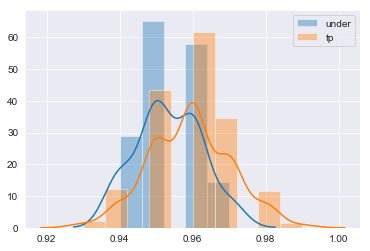


Percent of Students Chronically Absent - Under/TP
Ttest_indResult(statistic=2.6402996645360206, pvalue=0.008770949084751173)


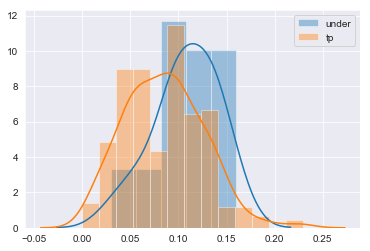

<Figure size 432x288 with 0 Axes>

In [60]:
for col in final_predict_df.columns[:-5]:
    print()
    under = under_performing_schools[col].values
    over =   over_performing_schools[col].values
    tp =                  tp_schools[col].values
    tn =                  tn_schools[col].values
        
    under_tp_test = stats.ttest_ind(under, tp)
    if round(under_tp_test[1], 2) <= .05:
        print(col, '- Under/TP')
        print(under_tp_test)
        sns.distplot(under, label='under')
        sns.distplot(tp, label='tp')
        plt.legend()
        plt.show()
        plt.clf()

And from this, we see that first and foremost, investment in making sure that students are in their class and not absent is the number one priority. Whether this means creating easier ways for children at these schools to get to the school itself, or a more concerted effort in making sure parents have the opportunity and drive to make sure their kids get to school will be determined on a school by school basis, and is beyond the scope of this investigation.

This should at least serve as a baseline for where the city needs to spend its valuable education resources to bring more minority students up in math scores so they can have a chance at attending the prestigous math and science prep schools in the city, so we can help close this gap in minority STEM representation.